# Emotion Detection in Twitter Data
The scope of this notebook is to implement a Naive-Bayes classifier that can be used to predict emotion in Twitter messages.

In [36]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import numpy as np
import re

Define the location of the training and testing sets.

In [37]:
# Global variables
dataDir = "Data/ssec-aggregated/"
trainFile = dataDir+"train-combined-0.0.csv"
testFile = dataDir+"test-combined-0.0.csv"


Here we define function to parse our training and testing sets.

**tokenizePhrase** takes a text message, removes @ mentions and # hashtags  as well as non-alphabetic characters and stop-words and returns the remaining words.

**parseSentence** Takes a line from the training or testing file,  separates and parses the sentiment fields and the message field and returns an array of boolean sentiment flags as well as a tokenised version of the sentence.

In [221]:
KnownSentiments = ["Anger", "Anticipation", "Disgust", "Fear", "Joy", "Sadness", "Surprise", "Trust"]
dropAts=True
dropHashtags=True

eng_stopwords = set(stopwords.words('english'))

def tokenizePhrase(phrase):
    # Drop @-references used in social media texts.
    if dropAts:
        phrase = re.sub("@[^ ]*", "", phrase)
        
    # Drop hashtags
    if dropHashtags:
        phrase = re.sub("#[^ ]*", "", phrase)
        
    # Change non-alphabetic characters to spaces
    phrase = re.sub("[^A-Za-z]", " ", phrase).lower()
    
    # Tokenize phrase while removing stop words and dropping tokens that are not more than 1 char long.
    tokens = [w for w in word_tokenize(phrase) if w not in eng_stopwords and len(w)>1]
    
    return tokens
    
def parseSentence(sent):
    # The sentiment labels are encoded at the beginning of the line as tab-separated fields
    # Split the line by tabs so as to extract the labels and the text
    parts = sent.split("\t")
    
    if len(parts)<9:
        return ([], [])
    
    sentSents = parts[:8]
    
    # Match the sentiment labels with the known sentiments to extract a boolean vector 
    # encoding which sentiments are present.
    sentMap = [sentSents[i]==KnownSentiments[i] for i in range(0, len(sentSents))]

    
    # The actual text
    phrase = parts[8]
    
    tokens = tokenizePhrase(phrase)
    
    #return the sentiment map and the tokens extracted from the phrase
    return (sentMap, tokens)
    



The **BoW** class implements Bag of Words. 

The **fit** method takes a collection of tokens and adds them to the Bag of Words.

The **transform** method takes a collection of tokens and returns a term-document vector correspondnding to the tokens

The **fit_transform** method combines the other fit and transform methods into one.

In [222]:
# Bag of Words
class BoW:

    def fit(self, phraseTokens):
        for tok in phraseTokens:
            if tok not in self.vocabulary_:
                tok_ndx = len(self.vocabulary_)
                self.vocabulary_[tok]=tok_ndx
                self.index_[tok_ndx]=tok
                 
    def transform(self, phraseTokens):
        return [i for i in [self.vocabulary_.get(t, None) for t in phraseTokens] if i is not None]
    
    def fit_transform(self, phraseTokens):
        self.fit(phraseTokens)
        return self.transform(phraseTokens)
    
    vocabulary_=dict()
    index_=dict()


Class **NaiveBayes1** is an implementation of the Naive Bayes multinomial classifier algorithm. 

Apart from label-wise prediction, NaiveBayes1 also maintains pairwise probabilities of labels, so for every pair of labels (X,Y), the class keeps track of P(X|Y), P(¬X|Y), P(X|¬Y) and P(¬X|¬Y). It also has the capability of accepting a set of pairwise dependencies to alter the final prediction probabilities. We can use this capability to skew the prediction probabilities towards a label **x** given an independent label-wise prediction **y**. For example, we can use this to model the probability of anger|fear, etc.

In [223]:
import math

# self.globalCounts[...] - Global count of every token
# self.labelWordCounts[<classes>, ...] - token count per label
# self.pairwiseCountsMatched[<classes>, <classes>, ...] 

# p(y|x) = p(x|y).p(y)
class NaiveBayes1:
    def __init__(self, classes):

        self.classes_=list(classes)
        print "Initialising NaiveBayes1 class with ", len(self.classes_), " classes..."
        self.globalCounts = np.zeros(1000) # pre-allocate 1000 tokens
        self.labelWordCounts = np.zeros((len(classes), 1000)) 
        self.pairwiseCountsMatched = np.zeros((len(classes), len(classes), 1000))
        self.pairwiseCountsMismatched = np.zeros((len(classes), len(classes), 1000))
        
        self.labelCounts = np.zeros(len(classes))
        self.documentCount = 0
        
    def update(self, labels, tokens):
        self.documentCount += 1
        
        #print(labels)
        for x in range(0, len(self.classes_)):
            #print(x)
            if labels[x]:
                self.labelCounts[x] += 1
            
        for w in tokens:
            toAdd=0
            # Does the word exist in our vocab?
            if w >= len(self.globalCounts):
                # No - extend the counts array to accomodate
                toAdd = int(math.ceil((w-len(self.globalCounts)+1) / 1000.0) * 1000)
                self.globalCounts = np.append(self.globalCounts, np.zeros(toAdd))

                
            self.globalCounts[w] += 1

            if toAdd>0:
                self.labelWordCounts = np.append(self.labelWordCounts, np.zeros((len(self.classes_),toAdd)), axis=1)
                self.pairwiseCountsMatched = np.append(self.pairwiseCountsMatched, np.zeros((len(self.classes_), len(self.classes_), toAdd)), axis=2) 
                self.pairwiseCountsMismatched = np.append(self.pairwiseCountsMismatched, np.zeros((len(self.classes_), len(self.classes_), toAdd)), axis=2)  

            for x in range(0, len(self.classes_)):
               
                if labels[x]:
                    self.labelWordCounts[x, w] += 1
                
                for y in range(0, len(self.classes_)):
                    if (y>x): # avoid count split in two elements
                        if labels[x]:
                            if labels[y]:
                                self.pairwiseCountsMatched[x,y, w]+=1 # x:y
                            else:
                                self.pairwiseCountsMismatched[x,y,w]+=1 # x:¬y
                    else:
                        if not labels[x]: 
                            if not labels[y]:
                                self.pairwiseCountsMatched[x, y, w]+=1 # ¬x:¬y
                            else:
                                self.pairwiseCountsMismatched[x, y, w]+=1 # ¬x:y
                            
        #self.recalc()
        
        
    def recalc(self):
        print("self.documentCount", self.documentCount)
        print("self.labelCounts=", self.labelCounts)
        globalTotal = sum(self.globalCounts)
        print(globalTotal)
        
        classProbs = np.array(self.labelWordCounts)
        print("classProbs", classProbs.shape)
        print("sum(classProbs)", sum(sum(classProbs)))

        print("self.labelWordCounts=", self.labelWordCounts+1)
        print("self.globalCounts=", self.globalCounts+len(classProbs)+1)
        # Laplace smoothed word probability by emotion - p(w|e) 
        # P(w|e) = count(w when e)/count(w)
        self.wordClassPosProbs = (1.0 * classProbs+1)/(self.globalCounts+len(classProbs))#/(globalTotal+len(classProbs))#(sum(classProbs)+len(classProbs)) # p(x|y)

        print("self.wordClassPosProbs", self.wordClassPosProbs.shape)
        print("self.wordClassPosProbs=", self.wordClassPosProbs)
        
        # emotion probability - p(e) 
        # p(e) = count()
        # sum classProbs per ROW to find total counts per class
        
        self.posClassProbs = (1.0 * self.labelCounts) / self.documentCount
        #self.posClassProbs = np.sum(classProbs, axis=1)
        #self.posClassProbs = (1.0*self.posClassProbs)/globalTotal#sum(self.posClassProbs) # p(y)
        print("self.posClassProbs", self.posClassProbs)
        print("self.posClassProbs", self.posClassProbs.shape)
        
        classProbs = self.globalCounts - self.labelWordCounts#np.array(self.globalCounts) - classProbs
        print("classProbs=", classProbs+1)
        # Laplace smoothed word probability by negative emotion - p(w|¬e)
        self.wordClassNegProbs = (1.0 * classProbs+1)/(self.globalCounts+len(classProbs)+1)#(globalTotal+len(classProbs))#(sum(classProbs)+len(classProbs))

        print("self.wordClassNegProbs", self.wordClassNegProbs.shape)
        print("self.wordClassNegProbs=", self.wordClassNegProbs)
        
        # negative emotion probability - p(¬e) - element per class
        self.negClassProbs = (1.0 *(self.documentCount-self.labelCounts)) / self.documentCount
        #self.negClassProbs = np.sum(classProbs, axis=1)
        #self.negClassProbs = (1.0*self.negClassProbs)/globalTotal#sum(self.negClassProbs) # p(¬y)
        print("self.negClassProbs", self.negClassProbs)
        print("self.negClassProbs", self.negClassProbs.shape)
        
        print(self.posClassProbs + self.negClassProbs)
        
        # pairwise emotion conditional probability - p(e1 | e2) - class x class
        tempCounts = np.sum(self.pairwiseCountsMatched, axis=2)
        self.pairwiseClassProbs_x_y_matched = np.zeros((len(self.classes_), len(self.classes_)))
        for x in range(0, len(self.classes_)):
            for y in range(0, len(self.classes_)):
                if x==y:
                    self.pairwiseClassProbs_x_y_matched[x, y]=1
                else:
                    if y > x: # p(x|y)
                        self.pairwiseClassProbs_x_y_matched[x, y] = (1.0*tempCounts[x, y])/(sum(self.labelWordCounts[y]))
                        self.pairwiseClassProbs_x_y_matched[y, x] = (1.0*tempCounts[y, x])/(sum(self.globalCounts)-sum(self.labelWordCounts[y]))
                        
        # p(¬e1|e1), p(e1|¬e2)                
        tempCounts = np.sum(self.pairwiseCountsMismatched, axis=2)
        self.pairwiseClassProbs_x_y_mismatched = np.zeros((len(self.classes_), len(self.classes_)))
        for x in range(0, len(self.classes_)):
            for y in range(0, len(self.classes_)):
                if x==y:
                    self.pairwiseClassProbs_x_y_mismatched[x, y]=0
                else:
                    if y > x:  
                        self.pairwiseClassProbs_x_y_mismatched[x, y] = (1.0*tempCounts[x, y])/(sum(self.labelWordCounts[y])) # p(x|¬y)
                        self.pairwiseClassProbs_x_y_mismatched[y, x] = (1.0*tempCounts[y, x])/(sum(self.globalCounts)-sum(self.labelWordCounts[y])) # p(¬x|y)

        # pairwise emotion conditional probability - p(e2 | e1) - class x class
        tempCounts = np.sum(self.pairwiseCountsMatched, axis=2)
        self.pairwiseClassProbs_y_x_matched = np.zeros((len(self.classes_), len(self.classes_)))
        for x in range(0, len(self.classes_)):
            for y in range(0, len(self.classes_)):
                if x==y:
                    self.pairwiseClassProbs_y_x_matched[x, y]=1
                else:
                    if y > x: # p(y|x)
                        self.pairwiseClassProbs_y_x_matched[x, y] = (1.0*tempCounts[x, y])/(sum(self.labelWordCounts[x]))
                        self.pairwiseClassProbs_y_x_matched[y, x] = (1.0*tempCounts[y, x])/(sum(self.globalCounts)-sum(self.labelWordCounts[x])) #p(¬y|¬x)

        # p(¬e2|e1), p(e2|¬e1)                
        tempCounts = np.sum(self.pairwiseCountsMismatched, axis=2)
        self.pairwiseClassProbs_y_x_mismatched = np.zeros((len(self.classes_), len(self.classes_)))
        for x in range(0, len(self.classes_)):
            for y in range(0, len(self.classes_)):
                if x==y:
                    self.pairwiseClassProbs_y_x_mismatched[x, y]=0
                else:
                    if y > x: # p(y|¬x)
                        self.pairwiseClassProbs_y_x_mismatched[x, y] = (1.0*tempCounts[x, y])/(sum(self.labelWordCounts[x]))
                        self.pairwiseClassProbs_y_x_mismatched[y, x] = (1.0*tempCounts[y, x])/(sum(self.globalCounts)-sum(self.labelWordCounts[x])) #\p(¬y|x)
                        
    # set pairs of classes to correlate in results
    # { 1: 2 } -> add p(c1|c2) to prediction
    # { -1: 2 } -> add p(¬c1|c2) to prediction
    # { 1: -2 } -> add p(c1|¬c2) to prediction
    
    def setPariwiseDependencies(self, classPairs):
        self.classPairs = classPairs
        
    def classify(self, tokens):

        classPredictions = [False] * len(self.classes_)
        
        posClassProbs=[1.0]*len(classPredictions)
        negClassProbs=[1.0]*len(classPredictions)
        
        for tok in tokens:
            if tok < len(self.globalCounts):
                posClassProbs *= self.wordClassPosProbs[:, tok]
            
                negClassProbs *= self.wordClassNegProbs[:, tok]
                
        posClassProbs *= self.posClassProbs
        negClassProbs *= self.negClassProbs
        
        preds = posClassProbs>negClassProbs

        for key, values in self.classPairs.iteritems():
            notKey = key<0
            for value in values:
                notValue = value<0
                #print key, value
                if abs(value) > abs(key):
                    #print "**********1" 
                    if key > 0:
                        #if (notValue and not preds[abs(value)-1]) or (not notValue and preds[abs(value)-1]):
                        if notValue:
                            #print "#b", key, value
                            posClassProbs[key-1] *= self.pairwiseClassProbs_x_y_mismatched[key-1, (-value)-1] * negClassProbs[(-value)-1]
                        else:
                            #print "#a", key, value, posClassProbs[key-1], self.pairwiseClassProbs_x_y_matched[key-1, value-1],  posClassProbs[value-1]
                            posClassProbs[key-1] *= self.pairwiseClassProbs_x_y_matched[key-1, value-1] * posClassProbs[value-1]

                    else:
                        #if (notValue and not preds[abs(value)-1]) or (not notValue and preds[abs(value)-1]):
                        if notValue:
                            #print "#d", key, value
                            negClassProbs[(-key)-1] *= self.pairwiseClassProbs_x_y_matched[(-value)-1, (-key)-1] * negClassProbs[(-value)-1]
                        else:
                            #print "#c", key, value
                            negClassProbs[(-key)-1] *= self.pairwiseClassProbs_x_y_mismatched[value-1, (-key)-1] *  posClassProbs[value-1]
                else:
                    #print "********2"
                    if key > 0:
                        #if (notValue and not preds[abs(value)-1]) or (not notValue and preds[abs(value)-1]):
                        if notValue:
                            posClassProbs[key-1] *= self.pairwiseClassProbs_y_x_mismatched[(-value)-1, key-1] * negClassProbs[(-value)-1]
                        else:
                            
                            posClassProbs[key-1] *= self.pairwiseClassProbs_y_x_matched[value-1, key-1] *  posClassProbs[value-1]
                    else:
                        #if (notValue and not preds[abs(value)-1]) or (not notValue and preds[abs(value)-1]):
                        if notValue:
                            negClassProbs[(-key)-1] *= self.pairwiseClassProbs_y_x_matched[ (-key)-1, (-value)-1] * negClassProbs[(-value)-1]
                        else:
                            #print "#b", key, value, posClassProbs[key-1], self.pairwiseClassProbs_x_y_matched[key-1, value-1],  posClassProbs[value-1]
                            negClassProbs[(-key)-1] *= self.pairwiseClassProbs_y_x_mismatched[(-key)-1, value-1] *  posClassProbs[value-1]
                        
                                            
        preds = posClassProbs>negClassProbs
        
        return preds
                    
        
    classes_=list()
    globalCounts=np.array([]) # array of counts indexed by token id
    labelWordCounts=np.array([]) # array of classes_ rows x tokens columns
    # array classes x classes x tokens
    # for y>x (top diagonal half) contains counts where sentiment(x) and sentiment(y)
    # for x<y (bottom diagonal half) contains counts where not(sentiment(x)) and not(sentiment(y))
    pairwiseCountsMatched=np.array([]) 
    
    # array classes x classes x tokens
    # for y>x (top diagonal half) contains counts where sentiment(x) and not(sentiment(y))
    # for x<y (bottom diagonal half) contains counts where not(sentiment(x)) and sentiment(y)
    pairwiseCountsMismatched=np.array([]) 
    classPairs=dict() # dict of emotion id -> emotion id

In [224]:
class ModelScores:
    def __init__(self, knownClasses):
        self.knownClasses = knownClasses
        self.truePositives = np.zeros(len(knownClasses))
        self.trueNegatives = np.zeros(len(knownClasses))
        self.falsePositives = np.zeros(len(knownClasses))
        self.falseNegatives = np.zeros(len(knownClasses))
        
    def accumulate(self, predictedLabels, trainingLabels):
        self.truePositives += np.logical_and(predictedLabels, trainingLabels)
        self.trueNegatives += np.logical_and(np.logical_not(predictedLabels), np.logical_not(trainingLabels))
        self.falsePositives += np.logical_and(preds, np.logical_not(trainingLabels))
        self.falseNegatives += np.logical_and(np.logical_not(preds), trainingLabels)

    def getStats(self):
        precision = self.truePositives / (self.truePositives+self.falsePositives)
        recall = self.truePositives / (self.truePositives+self.falseNegatives)
        accuracy = (self.truePositives+self.trueNegatives)/(self.truePositives+self.trueNegatives+self.falsePositives+self.falseNegatives)
        
        f1 = 2* ((precision * recall)/(precision + recall))
        
        return (accuracy, precision, recall, f1)
    
    def printScores(self):
        (accuracy, precision, recall, f1score) = self.getStats()
        print self.knownClasses
        print "true positives = ", self.truePositives
        print "true negatives = ", self.trueNegatives
        print "false positives = ", self.falsePositives
        print "false negatives = ", self.falseNegatives
        print
        print "accuracy=", np.round(accuracy, 3)
        print "precision=", np.round(precision, 3)
        print "recall=", np.round(recall, 3)
        print "f1score=", np.round(f1score, 3)
        
    def getDeltas(self, other):
        (o_accuracy, o_precision, o_recall, o_f1) = other.getStats()
        (accuracy, precision, recall, f1) = self.getStats()
        
        return (accuracy-o_accuracy, precision-o_precision, recall-o_recall, f1-o_f1)
    
    def printDeltas(self, other):
        (accuracy, precision, recall, f1) = self.getDeltas(other)
        
        print "delta accuracy=", np.round(accuracy, 3)
        print "delta precision=", np.round(precision, 3)
        print "delta recall=", np.round(recall, 3)
        print "delta f1score=", np.round(f1, 3)
        

## Part 1: Individual Emotions

Predict individual emotions based on the training data. 

No dependencies between different emotions.

In [227]:
bow = BoW() # Create empty Bag of Words
nb1 = NaiveBayes1(KnownSentiments) # Create Naive Bayes class with the known sentiments as labels.
i=0
# Process the training file line-by-line
for line in open(trainFile):
    #print i, line
    (classMap, tokens)=parseSentence(line) # Parse each sentence returning sentiments and tokens
    #print(i, ": ", classMap)
    if len(classMap)==0:
        i+=1
        continue
        
    token_ndx = bow.fit_transform(tokens) # Transform tokens to term-document frequency
    
    nb1.update(classMap, token_ndx) # Update the Naive Bayes class with the new training data
    
    i+=1
    
nb1.recalc() # Recalculate the probabilities


Initialising NaiveBayes1 class with  8  classes...
('self.documentCount', 2912)
('self.labelCounts=', array([1657., 1495., 1271., 1040., 1310., 1583.,  581., 1032.]))
21896.0
('classProbs', (8, 7000))
('sum(classProbs)', 77141.0)
('self.labelWordCounts=', array([[2., 3., 6., ..., 1., 1., 1.],
       [2., 3., 2., ..., 1., 1., 1.],
       [2., 3., 6., ..., 1., 1., 1.],
       ...,
       [2., 3., 5., ..., 1., 1., 1.],
       [2., 2., 2., ..., 1., 1., 1.],
       [1., 2., 1., ..., 1., 1., 1.]]))
('self.globalCounts=', array([10., 12., 14., ...,  9.,  9.,  9.]))
('self.wordClassPosProbs', (8, 7000))
('self.wordClassPosProbs=', array([[0.22222222, 0.27272727, 0.46153846, ..., 0.125     , 0.125     ,
        0.125     ],
       [0.22222222, 0.27272727, 0.15384615, ..., 0.125     , 0.125     ,
        0.125     ],
       [0.22222222, 0.27272727, 0.46153846, ..., 0.125     , 0.125     ,
        0.125     ],
       ...,
       [0.22222222, 0.27272727, 0.38461538, ..., 0.125     , 0.125     ,
  

In [226]:
nb1.setPariwiseDependencies({}) # Assume NO pairwise dependencies between labels
origScores = ModelScores(KnownSentiments)

# Process the test file
for line in open(testFile):
    # Parse, tokenise and BoW...
    (testClassMap, tokens) = parseSentence(line)
    if (tokens is None):
        continue
    tokens = bow.transform(tokens)
    # ... and use Naive Bayes to classify
    preds = nb1.classify(tokens)
     
    origScores.accumulate(preds, testClassMap)

origScores.printScores()
(orig_accuracy, orig_precision, orig_recall, orig_f1) = origScores.getStats()

['Anger', 'Anticipation', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust']
true positives =  [1176.  977.  477.  105.  353.  956.    2.  115.]
true negatives =  [ 180.  250.  777. 1099.  938.  200. 1426. 1233.]
false positives =  [531. 501. 267.  57. 261. 695.   3.  42.]
false negatives =  [ 69. 228. 435. 695. 404. 105. 525. 566.]

accuracy= [0.693 0.627 0.641 0.616 0.66  0.591 0.73  0.689]
precision= [0.689 0.661 0.641 0.648 0.575 0.579 0.4   0.732]
recall= [0.945 0.811 0.523 0.131 0.466 0.901 0.004 0.169]
f1score= [0.797 0.728 0.576 0.218 0.515 0.705 0.008 0.274]


## Part 2: Manual addition of relationships between emotion labels

### Part 2a: Pariwise combinations of 2 emotion labels.

We select Anger and Sadness and try all pairwise combinations of the two to determine the best combination

In [47]:
# Anger | Sadness
for label2 in [1, -1]:
    for label1 in [6, -6]:
        
        nb1.setPariwiseDependencies({label1:[label2]})
        scores = ModelScores(KnownSentiments)

        for line in open(testFile):
            (testClassMap, tokens) = parseSentence(line)
            if (tokens is None):
                continue
            tokens = bow.transform(tokens)
            preds = nb1.classify(tokens)

            scores.accumulate(preds, testClassMap)
                    
        if label1 < 0:
            NotChar1="¬"
        else:
            NotChar1=""
            
        if label2 < 0:
            NotChar2="¬"
        else:
            NotChar2=""
            
        print NotChar1+KnownSentiments[abs(label1)-1]+"|"+NotChar2+KnownSentiments[abs(label2)-1]
        scores.printScores()
        
        scores.printDeltas(origScores)
        
        print

Sadness|Anger
['Anger', 'Anticipation', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust']
true positives =  [1239. 1129.  664.  145.  510.    0.    0.  175.]
true negatives =  [  62.   89.  570. 1081.  724.  895. 1429. 1207.]
false positives =  [649. 662. 474.  75. 475.   0.   0.  68.]
false negatives =  [   6.   76.  248.  655.  247. 1061.  527.  506.]

accuracy= [0.665 0.623 0.631 0.627 0.631 0.458 0.731 0.707]
precision= [0.656 0.63  0.583 0.659 0.518   nan   nan 0.72 ]
recall= [0.995 0.937 0.728 0.181 0.674 0.    0.    0.257]
f1score= [0.791 0.754 0.648 0.284 0.586   nan   nan 0.379]
delta accuracy= [ 0.     0.     0.     0.     0.    -0.104  0.     0.   ]
delta precision= [ 0.  0.  0.  0.  0. nan nan  0.]
delta recall= [ 0.    0.    0.    0.    0.   -0.99  0.    0.  ]
delta f1score= [ 0.  0.  0.  0.  0. nan nan  0.]



/home/etienne/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()


¬Sadness|Anger
['Anger', 'Anticipation', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust']
true positives =  [1239. 1129.  664.  145.  510. 1061.    0.  175.]
true negatives =  [  62.   89.  570. 1081.  724.    0. 1429. 1207.]
false positives =  [649. 662. 474.  75. 475. 895.   0.  68.]
false negatives =  [  6.  76. 248. 655. 247.   0. 527. 506.]

accuracy= [0.665 0.623 0.631 0.627 0.631 0.542 0.731 0.707]
precision= [0.656 0.63  0.583 0.659 0.518 0.542   nan 0.72 ]
recall= [0.995 0.937 0.728 0.181 0.674 1.    0.    0.257]
f1score= [0.791 0.754 0.648 0.284 0.586 0.703   nan 0.379]
delta accuracy= [ 0.     0.     0.     0.     0.    -0.019  0.     0.   ]
delta precision= [ 0.     0.     0.     0.     0.    -0.011    nan  0.   ]
delta recall= [0.   0.   0.   0.   0.   0.01 0.   0.  ]
delta f1score= [ 0.     0.     0.     0.     0.    -0.007    nan  0.   ]

Sadness|¬Anger
['Anger', 'Anticipation', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust']
true positives =  [1239. 1

### Part 2b: Adding multiple relationships between labels manually (extra part - not in assignment)
Here we plot a heat map of pairwise class probability in order to see promising correlations between emotions. We use these heat maps to decide which relations to use to improve prediction performance.

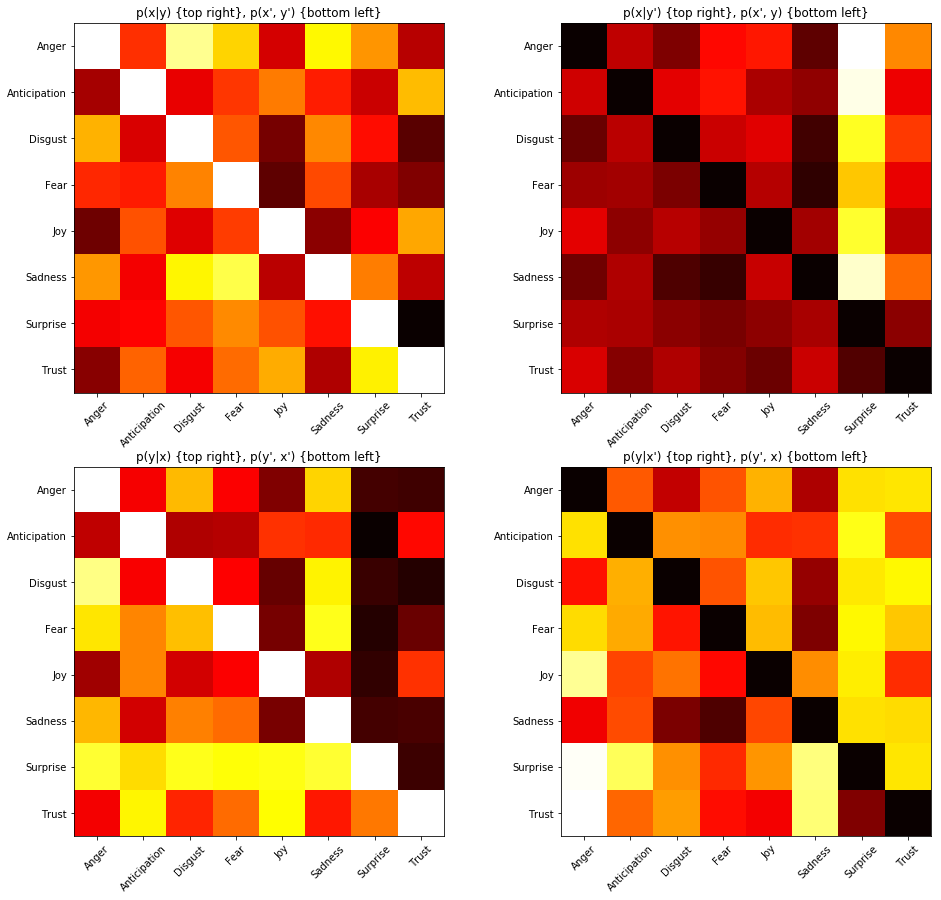

In [48]:
import matplotlib.pyplot as plt
import numpy as np

f, ([ax1, ax3], [ax2, ax4]) = plt.subplots(2, 2, figsize=(16, 10))
plt.subplots_adjust(bottom=-0.25)

sentLabels = [" "]
sentLabels.extend(KnownSentiments)
#test=np.array(np.zeros((8,8)))
#test[3,1]=1
#test  = np.transpose(test)
#ax1.imshow(test, cmap='hot', interpolation='nearest')
#ax1.set_title("p(x|y) {top right}, p(x', y') {bottom left}")
#ax1.set_yticklabels(sentLabels)
#ax1.set_xticklabels(sentLabels, rotation="45")

ax1.imshow(nb1.pairwiseClassProbs_x_y_matched, cmap='hot', interpolation='nearest')
ax1.set_title("p(x|y) {top right}, p(x', y') {bottom left}")
ax1.set_yticklabels(sentLabels)
ax1.set_xticklabels(sentLabels, rotation="45")

ax3.imshow(nb1.pairwiseClassProbs_x_y_mismatched, cmap='hot', interpolation='nearest')
ax3.set_title("p(x|y') {top right}, p(x', y) {bottom left}")
ax3.set_yticklabels(sentLabels)
ax3.set_yticklabels(sentLabels)
ax3.set_xticklabels(sentLabels, rotation="45")

ax2.imshow(nb1.pairwiseClassProbs_y_x_matched, cmap='hot', interpolation='nearest')
ax2.set_title("p(y|x) {top right}, p(y', x') {bottom left}")
ax2.set_yticklabels(sentLabels)
ax2.set_yticklabels(sentLabels)
ax2.set_xticklabels(sentLabels, rotation="45")

ax4.imshow(nb1.pairwiseClassProbs_y_x_mismatched, cmap='hot', interpolation='nearest')
ax4.set_title("p(y|x') {top right}, p(y', x) {bottom left}")
ax4.set_yticklabels(sentLabels)
ax4.set_yticklabels(sentLabels)
ax4.set_xticklabels(sentLabels, rotation="45")

plt.show()
#print nb1.pairwiseClassProbs

We would like to improve our prediction of "Sadness" whose accuracy is only slightly higher than 50%. According to the heat map, p(Sadness|fear), p(Sadness|disgust) and p(sadness|anger) are all quite high, therefore if we incorporate these correlations in our model, we should get a better prediction for "Sadness". 

It turns out, however that p(sadness|¬fear), p(sadness|¬disgust) and p(sadness|¬anger) are highly negatively correlated and these in the model gives a better prediction for sadness. Including both sets of correlations at the same time however is counterproductive. We manage to improve sadness accuract to 0.614 (up 5.2%).

In [61]:
#nb1.setPariwiseDependencies({6:[1,-7,-8], -8:[6], -7:[6]})
#nb1.setPariwiseDependencies({6:[1, 3, 4], -6:[7,8], 1:[6]})
#nb1.setPariwiseDependencies({6:[-1,-3,-4], -6:[-5, 7, 8]})
nb1.setPariwiseDependencies({6:[1]})#, -6:[-5, 7, 8]})

#nb1.setPariwiseDependencies({})

scores = ModelScores(KnownSentiments)

for line in open(testFile):
    (testClassMap, tokens) = parseSentence(line)
    if (tokens is None):
        continue
    tokens = bow.transform(tokens)
    preds = nb1.classify(tokens)
     
    scores.accumulate(preds, testClassMap)

scores.printScores()
scores.printDeltas(origScores)

Classify
**********1
#a 6 1 2.300508993773925e-05 0.6404536021345982 3.6585372669273685e-05
Classify
**********1
#a 6 1 3.996552325951143e-10 0.6404536021345982 4.900875261179947e-11
Classify
**********1
#a 6 1 5.575469877612238e-09 0.6404536021345982 2.4607690328109665e-09
Classify
**********1
#a 6 1 3.501662351681996e-06 0.6404536021345982 1.2490898579855904e-06
Classify
**********1
#a 6 1 1.9736977043530333e-08 0.6404536021345982 2.3250399270148623e-08
Classify
**********1
#a 6 1 4.3100885142240446e-08 0.6404536021345982 9.777193170434076e-08
Classify
**********1
#a 6 1 9.238306773829653e-05 0.6404536021345982 6.073012200367741e-05
Classify
**********1
#a 6 1 2.1309752984189396e-08 0.6404536021345982 2.8656351479483082e-08
Classify
**********1
#a 6 1 0.025312960560293248 0.6404536021345982 0.02795528976073279
Classify
**********1
#a 6 1 7.243945117483883e-13 0.6404536021345982 9.076527960110004e-13
Classify
**********1
#a 6 1 5.255935451896262e-06 0.6404536021345982 8.39591572346813

#a 6 1 7.775524418504235e-06 0.6404536021345982 2.3235908390478794e-06
Classify
**********1
#a 6 1 6.432376238765862e-12 0.6404536021345982 1.412951574747402e-10
Classify
**********1
#a 6 1 4.039275807795836e-06 0.6404536021345982 2.02636622401717e-06
Classify
**********1
#a 6 1 1.307645648266966e-07 0.6404536021345982 1.9689610841536393e-08
Classify
**********1
#a 6 1 1.0845621373860523e-11 0.6404536021345982 3.261139721757225e-11
Classify
**********1
#a 6 1 3.9131381218350813e-10 0.6404536021345982 7.97294855161507e-10
Classify
**********1
#a 6 1 7.1452096981580874e-09 0.6404536021345982 3.246612694528535e-08
Classify
**********1
#a 6 1 8.382863562175036e-07 0.6404536021345982 3.812084967372654e-06
Classify
**********1
#a 6 1 7.00081177452195e-14 0.6404536021345982 1.799965705202969e-14
Classify
**********1
#a 6 1 2.6490084435440546e-10 0.6404536021345982 2.871161496164987e-10
Classify
**********1
#a 6 1 3.4934495586384074e-10 0.6404536021345982 4.521477146756423e-10
Classify
*******

#a 6 1 0.0009926651200114999 0.6404536021345982 0.0007893258285383377
Classify
**********1
#a 6 1 5.936117198289183e-06 0.6404536021345982 2.7092711347883058e-06
Classify
**********1
#a 6 1 0.00017263741217591304 0.6404536021345982 5.362267856918055e-05
Classify
**********1
#a 6 1 6.4900485930456936e-09 0.6404536021345982 5.5404236444954105e-09
Classify
**********1
#a 6 1 2.0663641273708775e-05 0.6404536021345982 3.9936128229618274e-05
Classify
**********1
#a 6 1 1.0596739114722447e-05 0.6404536021345982 2.808694732632494e-05
Classify
**********1
#a 6 1 4.25565497421388e-08 0.6404536021345982 6.010908800552561e-08
Classify
**********1
#a 6 1 2.1066094438433963e-07 0.6404536021345982 5.1700241134106776e-08
Classify
**********1
#a 6 1 1.502186754102887e-06 0.6404536021345982 3.303757715698841e-06
Classify
**********1
#a 6 1 2.733429650478152e-08 0.6404536021345982 2.2392950399168063e-08
Classify
**********1
#a 6 1 1.4774782889382745e-11 0.6404536021345982 1.5238556000232265e-12
Classify


Classify
**********1
#a 6 1 5.317508635438605e-10 0.6404536021345982 1.5641496164476108e-09
Classify
**********1
#a 6 1 3.4889831696067024e-07 0.6404536021345982 1.067994073191881e-06
Classify
**********1
#a 6 1 3.5330292002016014e-10 0.6404536021345982 6.510855867841581e-10
Classify
**********1
#a 6 1 1.3266256410213627e-09 0.6404536021345982 1.946086564056704e-09
Classify
**********1
#a 6 1 3.057014882634779e-08 0.6404536021345982 5.565610234277846e-08
Classify
**********1
#a 6 1 2.3214586915792988e-10 0.6404536021345982 1.3897873185539448e-09
Classify
**********1
#a 6 1 6.575838092778632e-08 0.6404536021345982 5.10245593707941e-08
Classify
**********1
#a 6 1 1.4891266363151243e-09 0.6404536021345982 1.8150960930020171e-09
Classify
**********1
#a 6 1 1.740524205289121e-05 0.6404536021345982 2.7363710262185677e-05
Classify
**********1
#a 6 1 2.1282205341211937e-05 0.6404536021345982 2.2985752033986016e-05
Classify
**********1
#a 6 1 5.311547955181167e-11 0.6404536021345982 2.415717287

#a 6 1 2.4400560306428994e-11 0.6404536021345982 1.5321842825612067e-10
Classify
**********1
#a 6 1 1.1745318495853094e-09 0.6404536021345982 3.7158637194742267e-09
Classify
**********1
#a 6 1 2.143652270455321e-05 0.6404536021345982 2.574669373399968e-05
Classify
**********1
#a 6 1 2.0515115550267923e-07 0.6404536021345982 3.372465322185987e-07
Classify
**********1
#a 6 1 2.0421203022367814e-07 0.6404536021345982 3.4400214414284957e-07
Classify
**********1
#a 6 1 7.272271941476193e-07 0.6404536021345982 5.766132139223741e-07
Classify
**********1
#a 6 1 1.1800889346711885e-07 0.6404536021345982 5.701824571130329e-08
Classify
**********1
#a 6 1 1.0080917475351961e-08 0.6404536021345982 5.301537289680978e-09
Classify
**********1
#a 6 1 1.010448586611762e-09 0.6404536021345982 7.506747583960087e-09
Classify
**********1
#a 6 1 3.1330899471995912e-06 0.6404536021345982 1.1379384573026382e-05
Classify
**********1
#a 6 1 1.0357318021854916e-11 0.6404536021345982 3.698749989715318e-12
Classify

#a 6 1 1.1722890868520214e-12 0.6404536021345982 5.837312292065587e-12
Classify
**********1
#a 6 1 8.982479004103192e-09 0.6404536021345982 1.2820962851859803e-08
Classify
**********1
#a 6 1 1.4549152935867818e-08 0.6404536021345982 2.93262181054838e-08
Classify
**********1
#a 6 1 3.581494005364039e-08 0.6404536021345982 1.576673526330705e-07
Classify
**********1
#a 6 1 6.931378963628144e-09 0.6404536021345982 3.519190634241094e-08
Classify
**********1
#a 6 1 2.4574053749056074e-07 0.6404536021345982 4.2663117153610644e-07
Classify
**********1
#a 6 1 1.0765914007644242e-08 0.6404536021345982 4.227459261428376e-08
Classify
**********1
#a 6 1 2.0241934308939206e-06 0.6404536021345982 6.035536580474745e-06
Classify
**********1
#a 6 1 7.69750847447514e-07 0.6404536021345982 5.818445476516156e-06
Classify
**********1
#a 6 1 7.034191610058813e-07 0.6404536021345982 6.797407446490038e-07
Classify
**********1
#a 6 1 1.4089714463846195e-07 0.6404536021345982 6.68796828472835e-07
Classify
******

#a 6 1 4.399262684122106e-09 0.6404536021345982 1.2492927071414153e-08
Classify
**********1
#a 6 1 2.1991877104661022e-08 0.6404536021345982 1.7284433593244628e-08
Classify
**********1
#a 6 1 2.3392463530339476e-11 0.6404536021345982 2.435454547867788e-10
Classify
**********1
#a 6 1 1.8218106762546123e-12 0.6404536021345982 1.9496094464454323e-12
Classify
**********1
#a 6 1 1.4225578514702709e-05 0.6404536021345982 1.4314266820364804e-05
Classify
**********1
#a 6 1 5.5192605274574604e-08 0.6404536021345982 1.7997354897934174e-07
Classify
**********1
#a 6 1 2.2189708362214497e-08 0.6404536021345982 1.0505803859289606e-07
Classify
**********1
#a 6 1 3.823795290445409e-09 0.6404536021345982 1.3413859563879787e-08
Classify
**********1
#a 6 1 2.4894766106776115e-10 0.6404536021345982 9.228003283340979e-10
Classify
**********1
#a 6 1 1.872877505841123e-07 0.6404536021345982 6.163635459323333e-07
Classify
**********1
#a 6 1 0.00024816628000287497 0.6404536021345982 0.0006090477072055075
Class

#a 6 1 7.98117978897732e-08 0.6404536021345982 4.7044906176742357e-07
Classify
**********1
#a 6 1 2.591552975732125e-09 0.6404536021345982 1.6266131362668344e-09
Classify
**********1
#a 6 1 1.763681640399334e-09 0.6404536021345982 6.446748372765024e-09
Classify
**********1
#a 6 1 6.663459762255944e-06 0.6404536021345982 1.189618348820642e-05
Classify
**********1
#a 6 1 6.226268376422377e-07 0.6404536021345982 8.454601177801593e-07
Classify
**********1
#a 6 1 2.9762446279004407e-07 0.6404536021345982 4.944081718412961e-07
Classify
**********1
#a 6 1 6.612055300069633e-08 0.6404536021345982 1.1060497630451993e-07
Classify
**********1
#a 6 1 3.1377282286366933e-09 0.6404536021345982 1.0579007750870275e-09
Classify
**********1
#a 6 1 8.407330206721944e-06 0.6404536021345982 2.118127226055496e-05
Classify
**********1
#a 6 1 3.876842265517742e-08 0.6404536021345982 7.106083730193253e-08
Classify
**********1
#a 6 1 2.5869335919064634e-11 0.6404536021345982 4.343553145415184e-11
Classify
*****

**********1
#a 6 1 5.545139034010482e-07 0.6404536021345982 7.159722605384074e-07
Classify
**********1
#a 6 1 9.761751163390254e-08 0.6404536021345982 1.2583053236923122e-07
Classify
**********1
#a 6 1 1.894682676668656e-05 0.6404536021345982 4.0868394696056324e-05
Classify
**********1
#a 6 1 1.751258230617133e-14 0.6404536021345982 9.901782475767987e-15
Classify
**********1
#a 6 1 5.1365585552543126e-05 0.6404536021345982 8.824270757807069e-05
Classify
**********1
#a 6 1 5.77575027755895e-07 0.6404536021345982 6.733355696686048e-07
Classify
**********1
#a 6 1 1.4626132835300414e-07 0.6404536021345982 4.3074406410990435e-07
Classify
**********1
#a 6 1 5.168412126647427e-09 0.6404536021345982 3.020478953982217e-08
Classify
**********1
#a 6 1 1.3613561429246792e-05 0.6404536021345982 2.6203710609393905e-05
Classify
**********1
#a 6 1 5.927201132952905e-08 0.6404536021345982 2.493711956547555e-08
Classify
**********1
#a 6 1 3.689896691330642e-12 0.6404536021345982 8.10587179577378e-12
Cla

Classify
**********1
#a 6 1 7.283140826171332e-05 0.6404536021345982 0.00016086803570754165
Classify
**********1
#a 6 1 2.190454065966247e-11 0.6404536021345982 5.74110724054836e-11
Classify
**********1
#a 6 1 2.977102761067036e-11 0.6404536021345982 6.036368269856758e-11
Classify
**********1
#a 6 1 1.0483465290643694e-05 0.6404536021345982 6.918051567822714e-06
Classify
**********1
#a 6 1 2.4702819492379954e-06 0.6404536021345982 3.019421545129594e-06
Classify
**********1
#a 6 1 2.9620891255619134e-11 0.6404536021345982 1.3869099717461334e-10
Classify
**********1
#a 6 1 1.6683781204299008e-06 0.6404536021345982 3.9855624680749694e-06
Classify
**********1
#a 6 1 0.0005698155623962116 0.6404536021345982 0.0007261114223566959
Classify
**********1
#a 6 1 6.831610537254463e-07 0.6404536021345982 9.259932606194854e-07
Classify
**********1
#a 6 1 4.855771558374154e-08 0.6404536021345982 6.873939891569835e-07
Classify
**********1
#a 6 1 9.483328172942297e-11 0.6404536021345982 1.9365684713457

#a 6 1 3.640507432912081e-10 0.6404536021345982 1.2905395154008255e-10
Classify
**********1
#a 6 1 1.148367853344534e-09 0.6404536021345982 1.6779328749374828e-09
Classify
**********1
#a 6 1 3.4200463851312747e-09 0.6404536021345982 8.605050185087806e-10
Classify
**********1
#a 6 1 1.557898798818262e-10 0.6404536021345982 2.160785719833135e-10
Classify
**********1
#a 6 1 6.24704474490993e-09 0.6404536021345982 6.20610586142301e-09
Classify
**********1
#a 6 1 7.72164014604503e-11 0.6404536021345982 8.139853908591183e-11
Classify
**********1
#a 6 1 2.3002125048561018e-08 0.6404536021345982 2.7895609685815464e-08
Classify
**********1
#a 6 1 4.0986328450183996e-07 0.6404536021345982 8.094401339410287e-07
Classify
**********1
#a 6 1 2.171854187927349e-06 0.6404536021345982 3.469354768982282e-06
Classify
**********1
#a 6 1 2.8762377071834667e-11 0.6404536021345982 3.015004180093523e-11
Classify
**********1
#a 6 1 1.6681031699848415e-10 0.6404536021345982 3.06528204770806e-10
Classify
*******

Classify
**********1
#a 6 1 8.336877346730469e-07 0.6404536021345982 5.997790202928972e-07
Classify
**********1
#a 6 1 2.6164787937586293e-07 0.6404536021345982 6.470648138450081e-07
Classify
**********1
#a 6 1 5.090163832819757e-07 0.6404536021345982 1.1711474554140257e-06
Classify
**********1
#a 6 1 4.665602828141197e-11 0.6404536021345982 1.770341331113959e-10
Classify
**********1
#a 6 1 1.3854931888502048e-06 0.6404536021345982 2.1312383702177236e-06
Classify
**********1
#a 6 1 5.6319294968218676e-08 0.6404536021345982 1.1195687565553134e-07
Classify
**********1
#a 6 1 9.825959759634994e-10 0.6404536021345982 6.176436884536442e-09
Classify
**********1
#a 6 1 1.2733618255412555e-11 0.6404536021345982 2.5864128523261424e-11
Classify
**********1
#a 6 1 6.58287440268257e-08 0.6404536021345982 6.555939049502012e-08
Classify
**********1
#a 6 1 2.2862660953135846e-08 0.6404536021345982 8.135004526500216e-08
Classify
**********1
#a 6 1 8.108089998067457e-05 0.6404536021345982 0.00010928101

#a 6 1 2.377339713177152e-07 0.6404536021345982 7.35709998816425e-07
Classify
**********1
#a 6 1 7.243150536180983e-09 0.6404536021345982 9.19198043430714e-09
Classify
**********1
#a 6 1 1.9844077850069286e-07 0.6404536021345982 3.344456753273535e-07
Classify
**********1
#a 6 1 4.6566859040370875e-08 0.6404536021345982 1.275353701492497e-07
Classify
**********1
#a 6 1 3.347399193667978e-08 0.6404536021345982 3.6217020389164866e-08
Classify
**********1
#a 6 1 1.4219694458948437e-05 0.6404536021345982 5.9123831218101536e-06
Classify
**********1
#a 6 1 1.4221866384796842e-11 0.6404536021345982 1.5532942889518888e-11
Classify
**********1
#a 6 1 1.5057446225984758e-10 0.6404536021345982 3.9707484966488013e-10
Classify
**********1
#a 6 1 3.270456976300468e-09 0.6404536021345982 5.743729003062976e-09
Classify
**********1
#a 6 1 1.7752353960093304e-09 0.6404536021345982 1.2567350404318532e-09
Classify
**********1
#a 6 1 0.0034703252381047193 0.6404536021345982 0.004508917703343998
Classify
***

**********1
#a 6 1 3.774678534295302e-09 0.6404536021345982 4.484733892432381e-09
Classify
**********1
#a 6 1 1.917812618214148e-06 0.6404536021345982 1.686618173818438e-06
Classify
**********1
#a 6 1 3.0011073451647883e-09 0.6404536021345982 6.475615826991351e-09
Classify
**********1
#a 6 1 1.5948368529882914e-06 0.6404536021345982 3.1507988981332633e-06
Classify
**********1
#a 6 1 0.0006954110044036608 0.6404536021345982 0.0010944035139847316
Classify
**********1
#a 6 1 3.099785842761806e-08 0.6404536021345982 1.1816432013587113e-07
Classify
**********1
#a 6 1 1.6798544971303994e-08 0.6404536021345982 2.18494280609839e-08
Classify
**********1
#a 6 1 6.21399487338935e-09 0.6404536021345982 7.3528409139687184e-09
Classify
**********1
#a 6 1 0.0007417717380305715 0.6404536021345982 0.000819202630351144
Classify
**********1
#a 6 1 0.0006184984973409776 0.6404536021345982 0.0004018007870748515
Classify
**********1
#a 6 1 2.6478638610593893e-10 0.6404536021345982 9.942500579588599e-10
Clas

#a 6 1 1.5902320608867737e-06 0.6404536021345982 3.4148929974369953e-06
Classify
**********1
#a 6 1 5.8220520902438565e-08 0.6404536021345982 1.9093116008071065e-07
Classify
**********1
#a 6 1 1.9846674808163586e-08 0.6404536021345982 6.295850566963475e-08
Classify
**********1
#a 6 1 4.251118378619366e-10 0.6404536021345982 2.4533946750187458e-09
Classify
**********1
#a 6 1 1.3114891917067688e-08 0.6404536021345982 8.607579887510286e-08
Classify
**********1
#a 6 1 1.4045690503610585e-10 0.6404536021345982 3.679774463804011e-10
Classify
**********1
#a 6 1 2.612410541462147e-08 0.6404536021345982 6.197944130583109e-08
Classify
**********1
#a 6 1 1.1498180151592316e-06 0.6404536021345982 1.8122061755537862e-06
Classify
**********1
#a 6 1 1.9922221567901073e-12 0.6404536021345982 9.771863572265896e-12
Classify
**********1
#a 6 1 1.0383739333521998e-06 0.6404536021345982 2.457510990657458e-06
Classify
**********1
#a 6 1 7.928262645147052e-07 0.6404536021345982 2.7518434611278746e-07
Classif

/home/etienne/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()


### Part 3 - Best set of pairwise variable assignments
We now want to search through all pairwise combinations of emotions and all four combinations of conditional probability assignments (x|y, x|¬y, ¬x|y, ¬x|¬y) to find the best assignments. We perform a grid search over all the possible combinations and keep a record of those that improve prediction accuracy of x. Avoid taking x|y and x|¬y simultaneously.

In [76]:
globalPariwiseDependencies=dict()
(origAccuracy, origPrecision, origRecall, origf1) = origScores.getStats()

for x in range(0, len(KnownSentiments)):
    deltas = np.zeros((4, len(KnownSentiments))) # x|y, x|y', x'|y, x'|y'
    print deltas.shape
    
    for combination in range(0, 4):
        for y in range(0, len(KnownSentiments)):
            #print x, y
            if x!=y:
                sentx = KnownSentiments[x]
                senty = KnownSentiments[y]
                
                x1=x+1
                y1=y+1

                    
                if combination & 1:
                    y1=-y1
                    senty="!"+senty
                    
                if combination & 2:
                    x1=-x1
                    sentx="!"+sentx
                
                
                print "Evaluating P(", sentx, "|", senty, ")"
                   
                print({x1:[y1]})
                nb1.setPariwiseDependencies({x1:[y1]})

                scores = ModelScores(KnownSentiments)

                for line in open(testFile):
                    (testClassMap, tokens) = parseSentence(line)
                    if (tokens is None):
                        continue
                    tokens = bow.transform(tokens)
                    preds = nb1.classify(tokens)

                    scores.accumulate(preds, testClassMap)
                    
                (a, p, r, f1) = scores.getStats()
                (d_a, d_p, d_r, d_f1) = scores.getDeltas(origScores)
            
                #deltas[combination, y] = acc[x]-origAccuracy[x]
                deltas[combination, y] = d_a[x]
                print "    Edge changed accuracy from ", origAccuracy[x], " to ", a[x], "(" , deltas[combination, y], ")"
            
    

    print "Beneficial edges for ", KnownSentiments[x], ":"
    for y in range(0, len(deltas)):
        for combination in range(0, 4, 2):
            if x!=y:
                # Avoid adding both x|y and x|¬y - Choose the best option instead
                if (deltas[combination, y]>0) or (deltas[combination+1, y]>0): 
                    if deltas[combination, y] > deltas[combination+1, y]:
                        bestCombination = combination
                    else:
                        bestCombination = combination+1
                        
                    x1=x+1
                    y1=y+1
                    sentx = KnownSentiments[x]
                    senty = KnownSentiments[y]

                    if bestCombination & 1:
                        y1=-y1
                        senty="!"+senty

                    if bestCombination & 2:
                        x1=-x1
                        sentx="!"+sentx

                    print "P(", sentx, "|", senty, "), delta=", deltas[bestCombination, y]
                    if x1 in globalPariwiseDependencies:
                        globalPariwiseDependencies[x1].append(y1)
                    else:
                        globalPariwiseDependencies[x1]=[y1]

            

/home/etienne/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()


(4, 8)
Evaluating P( Anger | Anticipation )
{1: [2]}
    Edge changed accuracy from  0.6651329243353783  to  0.36349693251533743 ( -0.30163599182004086 )
Evaluating P( Anger | Disgust )
{1: [3]}
    Edge changed accuracy from  0.6651329243353783  to  0.36349693251533743 ( -0.30163599182004086 )
Evaluating P( Anger | Fear )
{1: [4]}
    Edge changed accuracy from  0.6651329243353783  to  0.36349693251533743 ( -0.30163599182004086 )
Evaluating P( Anger | Joy )
{1: [5]}
    Edge changed accuracy from  0.6651329243353783  to  0.36349693251533743 ( -0.30163599182004086 )
Evaluating P( Anger | Sadness )
{1: [6]}
    Edge changed accuracy from  0.6651329243353783  to  0.36349693251533743 ( -0.30163599182004086 )
Evaluating P( Anger | Surprise )
{1: [7]}
    Edge changed accuracy from  0.6651329243353783  to  0.36349693251533743 ( -0.30163599182004086 )
Evaluating P( Anger | Trust )
{1: [8]}
    Edge changed accuracy from  0.6651329243353783  to  0.36349693251533743 ( -0.30163599182004086 )
Ev

    Edge changed accuracy from  0.630879345603272  to  0.5337423312883436 ( -0.09713701431492838 )
Evaluating P( Disgust | Anticipation )
{3: [2]}
    Edge changed accuracy from  0.630879345603272  to  0.5337423312883436 ( -0.09713701431492838 )
Evaluating P( Disgust | Fear )
{3: [4]}
    Edge changed accuracy from  0.630879345603272  to  0.5337423312883436 ( -0.09713701431492838 )
Evaluating P( Disgust | Joy )
{3: [5]}
    Edge changed accuracy from  0.630879345603272  to  0.5337423312883436 ( -0.09713701431492838 )
Evaluating P( Disgust | Sadness )
{3: [6]}
    Edge changed accuracy from  0.630879345603272  to  0.5337423312883436 ( -0.09713701431492838 )
Evaluating P( Disgust | Surprise )
{3: [7]}
    Edge changed accuracy from  0.630879345603272  to  0.5337423312883436 ( -0.09713701431492838 )
Evaluating P( Disgust | Trust )
{3: [8]}
    Edge changed accuracy from  0.630879345603272  to  0.5337423312883436 ( -0.09713701431492838 )
Evaluating P( Disgust | !Anger )
{3: [-1]}
    Edge 

    Edge changed accuracy from  0.630879345603272  to  0.6129856850715747 ( -0.017893660531697275 )
Evaluating P( Joy | Disgust )
{5: [3]}
    Edge changed accuracy from  0.630879345603272  to  0.6129856850715747 ( -0.017893660531697275 )
Evaluating P( Joy | Fear )
{5: [4]}
    Edge changed accuracy from  0.630879345603272  to  0.6129856850715747 ( -0.017893660531697275 )
Evaluating P( Joy | Sadness )
{5: [6]}
    Edge changed accuracy from  0.630879345603272  to  0.6129856850715747 ( -0.017893660531697275 )
Evaluating P( Joy | Surprise )
{5: [7]}
    Edge changed accuracy from  0.630879345603272  to  0.6129856850715747 ( -0.017893660531697275 )
Evaluating P( Joy | Trust )
{5: [8]}
    Edge changed accuracy from  0.630879345603272  to  0.6129856850715747 ( -0.017893660531697275 )
Evaluating P( Joy | !Anger )
{5: [-1]}
    Edge changed accuracy from  0.630879345603272  to  0.6129856850715747 ( -0.017893660531697275 )
Evaluating P( Joy | !Anticipation )
{5: [-2]}
    Edge changed accurac

    Edge changed accuracy from  0.7305725971370143  to  0.7305725971370143 ( 0.0 )
Evaluating P( Surprise | Joy )
{7: [5]}
    Edge changed accuracy from  0.7305725971370143  to  0.7305725971370143 ( 0.0 )
Evaluating P( Surprise | Sadness )
{7: [6]}
    Edge changed accuracy from  0.7305725971370143  to  0.7305725971370143 ( 0.0 )
Evaluating P( Surprise | Trust )
{7: [8]}
    Edge changed accuracy from  0.7305725971370143  to  0.7305725971370143 ( 0.0 )
Evaluating P( Surprise | !Anger )
{7: [-1]}
    Edge changed accuracy from  0.7305725971370143  to  0.7305725971370143 ( 0.0 )
Evaluating P( Surprise | !Anticipation )
{7: [-2]}
    Edge changed accuracy from  0.7305725971370143  to  0.7305725971370143 ( 0.0 )
Evaluating P( Surprise | !Disgust )
{7: [-3]}
    Edge changed accuracy from  0.7305725971370143  to  0.7305725971370143 ( 0.0 )
Evaluating P( Surprise | !Fear )
{7: [-4]}
    Edge changed accuracy from  0.7305725971370143  to  0.7305725971370143 ( 0.0 )
Evaluating P( Surprise | !

Now re-classify the test set using the discovers relations.

In [24]:
print globalPariwiseDependencies

nb1.setPariwiseDependencies(globalPariwiseDependencies)

scores = ModelScores(KnownSentiments)

for line in open(testFile):
    (testClassMap, tokens) = parseSentence(line)
    if (tokens is None):
        continue
    tokens = bow.transform(tokens)
    preds = nb1.classify(tokens)
     
    scores.accumulate(preds, testClassMap)

scores.printScores()

scores.printDeltas(origScores)


{1: [2, -3, -4], 2: [1, 3, -4], 3: [1, 2, -4], 4: [-1, -2, -3], 5: [1, 2, 3, -4], 6: [-1, 2, -3, -4], 8: [-2, 3], -8: [1, 3], -6: [3], -5: [1], -4: [1, -2], -2: [1, -3]}
['Anger', 'Anticipation', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust']
true positives =  [1195.  982.  365.  152.  224.  834.    0.  164.]
true negatives =  [ 163.  234.  871. 1081. 1091.  342. 1429. 1229.]
false positives =  [548. 517. 173.  75. 108. 553.   0.  46.]
false negatives =  [ 50. 223. 547. 648. 533. 227. 527. 517.]

accuracy= [0.694 0.622 0.632 0.63  0.672 0.601 0.731 0.712]
precision= [0.686 0.655 0.678 0.67  0.675 0.601   nan 0.781]
recall= [0.96  0.815 0.4   0.19  0.296 0.786 0.    0.241]
f1score= [0.8   0.726 0.503 0.296 0.411 0.681   nan 0.368]
delta accuracy= [ 0.029 -0.001  0.001  0.004  0.041  0.039  0.     0.006]
delta precision= [0.029 0.025 0.095 0.011 0.157 0.048   nan 0.061]
delta recall= [-0.035 -0.122 -0.328  0.009 -0.378 -0.204  0.    -0.016]
delta f1score= [ 0.009 -0.027 -0.144

/home/etienne/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()


So from the above results it appears that we managed to increase the scores in all classes except anticipation which dropped .5% in accuracy. Clearly this strategy, while, on the whole, increasing the predictive performance of th model is not optimal. A perfect method would be to go through th entire search space of the problem, but for pairwise matching of emotions that would mean (8x8x4)! possible configurations, but this is not tractable.

A possible better method to search through this state space would possibly be a genetic algorithm.

In [44]:
import numpy as np

t = np.zeros((2, 3))
t[0,0]=1
t[1,0]=2
t[0,1]=2
t[1,2]=5
print(t)

#print(len(t))
#t2 = np.sum(t, axis=1)
#print(t2)
#t2/sum(t2)

[[1. 2. 0.]
 [2. 0. 5.]]


In [45]:
sum(t)

array([3., 2., 5.])

In [46]:
len(t)

2

In [134]:
t2 = [2, 2, 3]

t/t2

array([[0.5       , 1.        , 0.        ],
       [1.        , 0.        , 1.66666667]])

In [138]:
sum(t)-t

array([[2., 0., 5.],
       [1., 2., 0.]])